In [1]:
from google.colab import drive
drive.mount("drive")

Mounted at drive


# Setting Up Functions and Variables

In [3]:
#Importing relevant libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import h5py
import matplotlib
import matplotlib.pyplot as plot
from scipy.interpolate import interp1d
from scipy.integrate import simps
import scipy.stats
from scipy.stats import skewnorm
import matplotlib.pyplot as plt
import random

In [4]:
#Declaring constants
detector_bin_count = 128
twopi = 2*(np.pi)
MeV = 1.602176565e-13
GeV = 1.602176565e-10
detection_factor = 1.0
model_correction_factor = 8.1e-07

#Update this code_directory path depending on where this notebook and folder are located

code_directory_path = "/content/drive/MyDrive/Multishot Code Helper Files/"

In [5]:
#Declaring relevant functions

#Implementation of the MLE algorithm
def iterate_shepp_vardi(x0, R, y):
  y0 = np.matmul(x0, R)
  mask = (y0 != 0)
  yrat = np.zeros_like(y)
  yrat[mask] = y[mask]/y0[mask]
  return (x0/R.sum(axis=1)) * np.matmul(R, yrat)

def load_response(fin):
  num_events = fin['num_events'][:].flatten()
  num_gamma_bins = len(num_events)
  gamma_bins = fin['i0'][:]*MeV
  hits = fin['hits'][:]
  detector_bins = fin['detector_bin'][:]
  photon_bins = fin['photon_bin'][:]*MeV

  # sum over photon energies
  hits = hits.sum(axis=2) * detection_factor

  hits = hits.astype('float64')
  num_cells = hits.shape[1]

  R = hits/num_events[:,np.newaxis]
  return R, gamma_bins, detector_bins

with h5py.File(code_directory_path + "R.h5","r") as f:
  R_test, gamma_bins, detector_bins = load_response(f)

def photon_spectral_density_func(E):
  E0 = 1*GeV
  sigma0 = 2*GeV
  total_num_photons = 1e10
  A0 = total_num_photons/np.sqrt(twopi*sigma0**2)
  return A0 * np.exp(-(E-E0)**2/(2*sigma0**2))

#Plotting spectral photon density for the Nonlinear Compton Scattering case
def plot_spectral_photon_density_ncs(
        ax, filename, E_lim, num_photons_simulated, gamma_bins):
    photon_energy, spectral_photon_density = np.loadtxt(filename).T
    photon_energy *= GeV
    spectral_photon_density *= (1/(0.05*GeV))

    photon_energy, spectral_photon_density = resample(
        photon_energy, spectral_photon_density, 1000)

    mask = spectral_photon_density>0

    idx = range(*photon_energy.searchsorted(E_lim))
    num_photons_lim = simps(spectral_photon_density[idx], photon_energy[idx])
    alpha = num_photons_simulated/num_photons_lim

    ax.loglog(
        np.concatenate(((0.0,), photon_energy[mask]/GeV)),
        alpha*np.concatenate(((0.0,), spectral_photon_density[mask]/(1/GeV))),
        linewidth=0.6, label='Incident gamma spectrum')
    return generate_short_true_spectrum(np.concatenate(((0.0,), photon_energy[mask]/GeV)),
        alpha*np.concatenate(((0.0,), spectral_photon_density[mask]/(1/GeV))))

    #photon_energy[mask][1:]/GeV * (alpha*(spectral_photon_density[mask][1:] - spectral_photon_density[mask][:-1])/(1/GeV))

def resample(x, y, N):
    # import ipdb
    # ipdb.set_trace()
    x_y = interp1d(x, y, kind='linear')
    x0 = x[0]
    x1 = x[-1]
    u = 10**np.linspace(np.log10(x0), np.log10(x1), N)
    u[0] = x0
    u[-1] = x1
    v = x_y(u)
    return u, v

def find_nearest(array, value):
  array = np.asarray(array)
  idx = (np.abs(array-value)).argmin()
  return idx

def plot_spectral_photon_density(
        ax, fin, group_name, E_lim, num_photons_simulated, gamma_bins):
    mrad = 0.001
    joule = 1.0
    g = fin[group_name]
    photon_energy = g['energy'][:]*MeV
    thetax = g['thetax'][:]*mrad
    thetay = g['thetay'][:]*mrad
    d2W = g['d2W'][:]*joule/(mrad**2*MeV)
    dthetax = thetax[1]-thetax[0]
    dthetay = thetay[1]-thetay[0]

    spectral_energy_density = d2W.sum(axis=(1,2))*dthetax*dthetay
    spectral_photon_density = spectral_energy_density/photon_energy

    mask = spectral_energy_density>0

    idx = range(*photon_energy.searchsorted(E_lim))
    num_photons_lim = simps(spectral_photon_density[idx], photon_energy[idx])
    alpha = num_photons_simulated/num_photons_lim

    ax.loglog(
        np.concatenate(((0.0,), photon_energy[mask]/GeV)),
        alpha*np.concatenate(((0.0,), spectral_photon_density[mask]/(1/GeV))),
        linewidth=0.6, label='Incident gamma spectrum')
    return generate_short_true_spectrum(np.concatenate(((0.0,), photon_energy[mask]/GeV)),
        alpha*np.concatenate(((0.0,), spectral_photon_density[mask]/(1/GeV))))
    #photon_energy[mask]/GeV * (alpha * spectral_photon_density[mask]/(1/GeV))

def generate_short_true_spectrum(real_x_values, real_y_values):
    with h5py.File(code_directory_path+'spectrum.h5', 'r') as fin:
        energy_bins = fin['energy_bins'][:]*MeV
        photon_spectral_density = fin['photon_spectral_density'][:]*(1/MeV)
        num_events = fin['num_events'][:]

    x_values = energy_bins[0:-1]/GeV
    y_values = photon_spectral_density/(1/GeV)

    short_gamma_distribution = []

    for i in range(0, len(x_values)):
        index = find_nearest(real_x_values, x_values[i])
        short_gamma_distribution.append(real_y_values[index])
    return short_gamma_distribution

def plot_spectrum(spec_to_plot, dE, gamma_bins, title):
  spectral_density = spec_to_plot/dE
  ax.loglog(
        gamma_bins/GeV,
        np.concatenate(((0.0,),spectral_density/(1/GeV))),
        linewidth=0.6, label=title, ds = "steps")

# This function will attempt to reconstruct a given (or random) gamma distribution after converting into a PEDRO spectrum
def gamma_dist_pred_and_plot(energy_bin, dist = np.zeros(shape=(1,64))):
  arb_gamma_distrbution = np.zeros(shape=(1,64))

  if (np.array_equal(dist,arb_gamma_distrbution)):
    for i in range(0, len(energy_bin)):
      #Decreasing Sigmoid: 1e11*(1 - 1/(1+np.exp(-((i+1)/8 - 4)))), 1e11*(1 - 1/(1+np.exp(-((i+0)/8 - 4))))
      #Exponential: 1e10*np.exp(i/64), 1e10*np.exp((i+1)/64)
      #Logarithmic: (64-(i+1))*1e10/64, (64-i)*1e10/64
      #Random: 0, 1e10
      rand_freq = np.random.randint(0, 1e10)
      arb_gamma_distrbution[0][energy_bin[i]] = rand_freq
  else:
    arb_gamma_distrbution[0] = dist

  #Calculating the simulated spectrum by multiplying the distribution with the R matrix
  y_experiment = np.dot(arb_gamma_distrbution[0], R)

  #Applying the ML model to reconstruct the gamma distribution
  output=model(tf.convert_to_tensor([y_experiment]))
  num_events = output.numpy()[:]
  x=num_events[0]

  #Using the ML reconstruction as the initial guess for MLE
  x_s = x
  for i in range(75):
    x_s = iterate_shepp_vardi(x_s, R, y_experiment)

  scale_factor_list = []

  #Predicts the distribution 100 times and calculates the scale difference between the first element of the guess and original gamma distribution each time
  for i in range (0, 100):
    output=model(tf.convert_to_tensor([y_experiment]))
    num_events = output.numpy()[:]
    x=num_events[0]
    scale_factor_list.append(arb_gamma_distrbution[0][0]/x[0])

  #Calculating the average scale factor and printing it
  scale_factor = np.mean(scale_factor_list)
  print(scale_factor)
  scale_factor = 1

  #Plotting the ML guess (with the scale_factor correction) with the original gamma distribution
  gamma_dist_plot(x*scale_factor, arb_gamma_distrbution[0])

def gamma_dist_plot(prediction, true):
  qr_guess = recover_energy_dist(R, np.dot(prediction, R))
  plot.plot(prediction, label = "Model based prediction")
  #plot.plot(qr_guess[0], label = "QR based prediction")
  plot.plot(true, label = "Gamma distribution")
  plot.title("Comparison of Gamma Energy Distributions")
  plot.xlabel("Energy Bin")
  plot.ylabel("Number of Photons")
  plot.yscale("log")
  plot.legend()

#Implementation of the QR decomposition-based reconstruction method
def recover_energy_dist(R, spectrum): #R*guess = spectrum
  Q,S = np.linalg.qr(np.matrix.transpose(R), mode = "complete") #Q*S*guess = spectrum
  b = np.array([np.matrix.transpose(Q).dot(spectrum)], dtype="float") #S*guess = Q^t * spectrum = b
  guess = np.linalg.lstsq(S,b[0],) # || S*guess - b ||_2 = 0
  return guess

In [6]:
#Loading the data
f = h5py.File(code_directory_path + "R.h5","r")
data = f["hits"]

#Constructing the data structures to pass to the model
R = np.empty(shape = (64, detector_bin_count), dtype = object) #R matrix
train_hits = np.empty(shape = (64, detector_bin_count), dtype = object) #MODEL INPUT
train_spectra = np.zeros(shape = (64, 64), dtype = object) #MODEL OUTPUT

#Creating the arrays to contain the testing data.
test_hits = np.zeros(shape = (1, detector_bin_count), dtype = object)
test_spectra = np.zeros(shape = (1, 64), dtype = object)

energy_bins = f["num_events"][:]
noise_level = 1e04

for i in range(0, 64):
  train_spectra[i][i] = energy_bins[i]
  vector = []
  for k in range(0, detector_bin_count):
    vector.append(detection_factor*sum(data[i][k])/1e09)
  R[i] = vector
  train_hits[i] = np.dot(train_spectra[i][i], R[i])

num_of_training_cases = 4

#The following loop randomly generates num_of_training_cases by randomly creating photon distributions and calculating the
#associated electron-positron hits to provide to the model as training data.
for i in range(0, num_of_training_cases):
  arb_gamma_distrbution = np.zeros(shape=(1,64))
  #Creating an array of bins to generate a random number of photons
  #Consider generating random weights within the space of all betatron functions
  #Should be a 2D search space
  #This can yield a library of neural networks trained on different physical cases
  #Eg: energy_bin = [0, 24, 36, 52, 14, 9, 61] when i%12 = 7
  #energy_bin = np.random.randint(0, 64, 64)

  for k in range(0, 64):
    interval_index = np.random.randint(1,4)
    arb_gamma_distrbution[0][k] = np.random.randint(10**(interval_index-1), 10**(interval_index+1)) #Adding a random number of photons between 0 and 1e10 in each bin based on energy_bin

  #Calculating the simulated hits in the PEDRO detector by multiplying the arbitrary gamma distrbution with the R matrix
  calculated_hits = np.zeros(shape=(1,detector_bin_count))
  calculated_hits[0] = np.dot(arb_gamma_distrbution[0], R)
  calculated_hits = calculated_hits + np.random.poisson(noise_level, detector_bin_count) #Adding some noise to the data

  #Adding the simulated hits and gamma distribution to the training data
  train_hits  = np.concatenate((train_hits, calculated_hits))
  train_spectra = np.concatenate((train_spectra, arb_gamma_distrbution))

#The following loop is creating testing data for the model.
#Consider adding noise to the testing data, but not to the training data?
test_cases = int(num_of_training_cases/10)
for i in range(0, test_cases):
  arb_gamma_distrbution = np.zeros(shape=(1,64))

  for k in range (0, 64):
    interval_index = np.random.randint(1,10)
    arb_gamma_distrbution[0][k] = np.random.randint(10**(interval_index-1), 10**(interval_index+1)) #Adding a random number of photons between 0 and 1e10 in each bin based on energy_bin

  calculated_hits = np.zeros(shape=(1,detector_bin_count))
  calculated_hits[0] = np.dot(arb_gamma_distrbution[0], R)
  calculated_hits = calculated_hits + np.random.poisson(noise_level, detector_bin_count) #Adding some noise to the data

  test_hits  = np.concatenate((test_hits, calculated_hits))
  test_spectra = np.concatenate((test_spectra, arb_gamma_distrbution))

#Converting the arrays into formats the model can process
train_hits = tf.convert_to_tensor(train_hits, dtype=float)
train_spectra = tf.convert_to_tensor(train_spectra, dtype=float)
test_hits = tf.convert_to_tensor(test_hits, dtype=float)
test_spectra = tf.convert_to_tensor(test_spectra, dtype=float)

# Training and Saving Model

To plot graphs, you need to use photon density against the energy. Divide the photons in each bin by (energy_max - energy_min) as the y-values. Plot using the step graph method with matplotlib (google it).

Currently, you're trying to find out how to calculated the energy bin lengths (the differences) and are having trouble keeping track of the units


In [7]:
#For this model, I want to provide a vector/list of 128 elements and associate that with a 64-bin spectrum.
#2 layers proved to be more effective than 1 layer or 3 layers
model = keras.Sequential(
  [
   layers.Dense(64, activation='linear', use_bias=True, input_shape=(128,)),
   layers.Dense(64, activation='linear', use_bias=True, input_shape=(64,))
   ]
)

#Learning rate of 0.005 was chosen after hyperparameter tuning
opt = keras.optimizers.Adam(learning_rate=0.005)

model.compile(optimizer=opt,loss=tf.keras.losses.mse, metrics='accuracy')
model.fit(train_hits, train_spectra, epochs = 400, verbose=0)
print("Evaluate on test data")
results = model.evaluate(test_hits, test_spectra)
print("test loss, test acc:", results)

Evaluate on test data
1/1 [==============================] - 0s 101ms/step - loss: 757.5728 - accuracy: 1.0000
test loss, test acc: [757.57275390625, 1.0]


In [8]:
model.save(code_directory_path + "pair_model.h5")

# Load Model and Test Single Shot Reconstruction

In [9]:
model = keras.models.load_model(code_directory_path + "pair_model.h5")

1.04807996326256


<ipython-input-5-1248c4deab17>:192: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  guess = np.linalg.lstsq(S,b[0],) # || S*guess - b ||_2 = 0


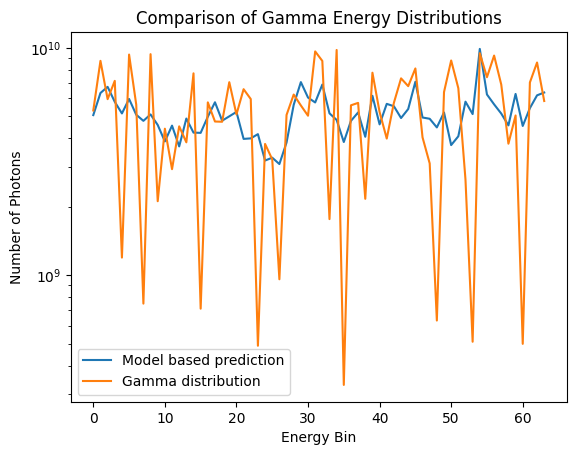

In [10]:
e_bins = np.indices((1,64))
gamma_dist_pred_and_plot(e_bins[1][0])

Regarding the last code block, if you see an indexing error involving the variable arb_gamma_distribution, rerun the block 1-2 more times and the error should be resolved. This is the result of the order in which the variables are loaded.

<ipython-input-5-1248c4deab17>:192: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  guess = np.linalg.lstsq(S,b[0],) # || S*guess - b ||_2 = 0


test


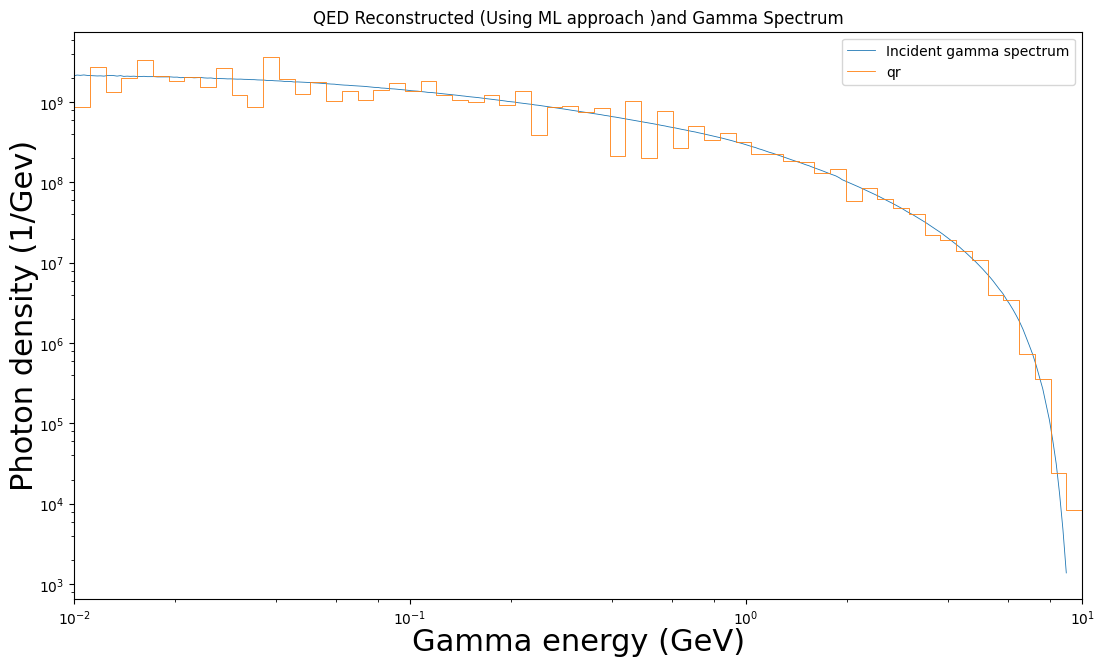

In [12]:
#For the .h5 file, use the following key:
# nlcs.h5 for Nonlinear Compton Scatter
# filamentation.h5 for Filamentation
# qed.h5 for Quantum Electrodynamics
with h5py.File(code_directory_path + 'qed.h5', 'r') as fin:
  y_experiment = fin['hits'][0,:]
  y_experiment = y_experiment.sum(axis=1)
  y_experiment = y_experiment.astype('float64')
  num_events_real = fin['num_events'][:]

with h5py.File(code_directory_path + "R.h5","r") as f:
  R_test, gamma_bins, detector_bins = load_response(f)

dE = gamma_bins[1:] - gamma_bins[:-1]
energy = gamma_bins[:-1] + 0.5*dE
x0 = photon_spectral_density_func(energy)

#The following set of lines (until y_experiment = np.dot(arb_gamma_distrbution[0], R)) can be used to implement different cases
#Uncomment the following line and all lines associated with each case to test it. Don't forget to comment the last 4 lines of
#this code block to avoid loading the experimental cases

arb_gamma_distrbution = np.zeros(shape=(1,64)) #Setting the gamma distribution equal to 0

#Monoenergetic Spectrum
#arb_gamma_distrbution[0][2] = 1e08 #Adding one arbitrary spike (the second index indicates the bin)

noise_level = 1e02

#Bienergetic Spectrum
arb_gamma_distrbution[0][2] = 1e08 #Adding one arbitrary spike (the second index indicates the bin)
arb_gamma_distrbution[0][42] = 1e10  #Adding another arbitrary spike (the second index indicates the bin)

#Random Spectrum across all 64 bins
#for i in range(0, 64):
#  rand_freq = np.random.randint(0, 1e10)
#  arb_gamma_distrbution[0][i] = rand_freq

#Calculating the hits in each detector by multiplying the gamma distribution by the R matrix
#y_experiment = np.dot(arb_gamma_distrbution[0], R) + np.random.poisson(noise_level, detector_bin_count) #Adding some noise to the data
#y_experiment += np.random.poisson(noise_level, detector_bin_count) #Adding some noise to the data
gamma_dist = GeV * arb_gamma_distrbution[0]/dE

#Adding Gaussian noise
#Take peak spectrometer signal, /2^8, treat that a standard deviation for a GD with a mean of 0, add to spectrometer signal and make sure there are no negative values

#Reconstructing the spectrum using QR decomposition
qr_guess = recover_energy_dist(R, y_experiment)

#Converting the experimental values into a reconstructed spectrum using the ML model
output=model(tf.convert_to_tensor([y_experiment]))
num_events = output[:]

model_guess = num_events[0]

#Reconstructing the spectrum using Maximum-Likelihood Estimation with the ML model's guess provided as the initial guess
mle_guess = model_guess
for i in range(5):
  mle_guess = iterate_shepp_vardi(mle_guess, R, y_experiment)

photon_spectral_density = model_guess[0]/dE
E_lim = [energy_bins[0], energy_bins[-1]]


#Code to write the information into a spectrum h5 file
with h5py.File(code_directory_path + 'spectrum.h5', 'w') as fout:
  fout['num_events'] = num_events_real
  fout['energy_bins'] = gamma_bins/MeV
  fout['photon_spectral_density'] = photon_spectral_density/(1/MeV)

#Include short paragraph about how we could use this to reconstruct multishot cases

matplotlib.rc(
        'figure.subplot', right=0.97, top=0.96, bottom=0.15, left=0.13)
fig = plot.figure(figsize=(12.0, 7.0))
ax = fig.add_subplot(1, 1, 1)

with h5py.File(code_directory_path + 'spectrum.h5', 'r') as fin:
        energy_bins = fin['energy_bins'][:]*MeV
        photon_spectral_density = fin['photon_spectral_density'][:]*(1/MeV)
        num_events = fin['num_events'][:]

plot.xlabel('Gamma energy (GeV)', labelpad=0.0, fontsize=22)
plot.ylabel(r'Photon density (1/Gev)', labelpad=0.0, fontsize=22)
photon_spectral_density = num_events[0]/dE

#Insert variable into the plot_spectral_photon_density depending on whether you're running filamentation or qed respectively
filamentation_group = '/Filamentation/solid'
sfqed_group = '/SFQED/MPIK/LCS+LCFA_w2.4_xi7.2'

#If testing the arbitrary gamma distributions, comment out all of the following lines
with h5py.File(code_directory_path + 'd2W.h5', 'r') as fin:
  #If running Nonlinear Compton scattering case, comment the following line and uncomment the last line
  gamma_dist = plot_spectral_photon_density(ax, fin, sfqed_group, E_lim, num_events, gamma_bins)
  print("test")

#Uncomment only when running Nonlinear Compton scattering case; else comment out
#gamma_dist = plot_spectral_photon_density_ncs(ax, code_directory_path +'nonlinear-compton-scattering.dat', E_lim, num_events, gamma_bins)

#plot_spectrum(np.abs(model_guess.numpy()), dE, gamma_bins, "model")
#plot_spectrum(np.abs(mle_guess), dE, gamma_bins, "mle")
plot_spectrum(np.abs(qr_guess[0]), dE, gamma_bins, "qr")
#plot_spectrum(arb_gamma_distrbution[0], dE, gamma_bins, "Incident Gamma Spectrum")

#Setting the title and finalizing the visual appearance of the Reconstruction Plot
ax.set_title("QED Reconstructed (Using ML approach )and Gamma Spectrum")
ax.legend()
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12)
ax.yaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax.yaxis.set_minor_locator(locmin)

ax.set_xlim(gamma_bins[0]/GeV, gamma_bins[-1]/GeV)
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12)
ax.xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax.xaxis.set_minor_locator(locmin)

resolution_value = 600
#plot.savefig(code_directory_path + "PEDRO_Reconstruction_Images/" + "filamentation_QR.png", format="png", dpi=resolution_value, bbox_inches='tight')

# Multishot Modeling


In [13]:
arb_gamma_distribution = np.zeros(shape=(1,64))
#arb_gamma_distribution[0] = QED
n = 111 #number of energy subdistributions
max_loc_value = n//2
max_offset_length = 10 # mm
max_skew = 8
shots = np.zeros(shape=(n, 64))
for k in range(0, 64):
  interval_index = np.random.randint(6,8)
  arb_gamma_distribution[0][k] = np.random.randint(10**(interval_index-1), 10**(interval_index+1))
  for photon in range(int(arb_gamma_distribution[0][k]/1e04)):
    offset = (max_offset_length-2)*k/64
    skew = max_skew*k/64

    alpha = 1
    if np.random.choice([0,1]) == 0:
      alpha = -1

    random_location = skewnorm.rvs(-1*alpha, size=1)[0] + alpha*offset

    if random_location > 11:
      random_location = 11
    elif random_location < -11:
      random_location = -11

    random_location = int(np.round(random_location*max_loc_value/10))

    shots[random_location][k] += 1e04

#qr_guess = recover_energy_dist(R, y)
#plt.plot(gamma_bins[1:]/GeV, qr_guess[0]/dE/(1/GeV), label="QR")
#plt.plot(gamma_bins[1:]/GeV, arb_gamma_distribution[0]/dE/(1/GeV), label="OG")
#plt.xlabel("Energy (GeV)")
#plt.ylabel("Photon Density (1/GeV)")
#plt.yscale("log")
#plt.xscale("log")
#plt.title("Comparison of Reconstruction in Multishot Environment")
#plt.legend()

In [14]:
test = [ [] for _ in range(64) ]
step_size = 10
for j in range(64):
  for i in range(0, 111, step_size):
    test[j].append(shots[i][j])

auc = []
area_to_append = 0
for j in range(64):
  area_to_append = 0
  for i in range(len(test[j])-1):
    area_to_append += step_size*(test[j][i]+test[j][i+1])/2
  auc.append(area_to_append)
print(auc)

[8750000.0, 9050000.0, 6600000.0, 7050000.0, 7100000.0, 18000000.0, 250000.0, 43150000.0, 3450000.0, 23200000.0, 62800000.0, 47150000.0, 78650000.0, 2450000.0, 5800000.0, 96500000.0, 55500000.0, 67700000.0, 9600000.0, 5400000.0, 32300000.0, 9750000.0, 900000.0, 14850000.0, 76150000.0, 4450000.0, 60100000.0, 72800000.0, 8250000.0, 5300000.0, 100000.0, 13100000.0, 3600000.0, 40450000.0, 1200000.0, 73400000.0, 78350000.0, 4800000.0, 0.0, 57300000.0, 67100000.0, 64200000.0, 400000.0, 9200000.0, 92200000.0, 6100000.0, 67100000.0, 4700000.0, 10400000.0, 104800000.0, 6500000.0, 9600000.0, 31200000.0, 17500000.0, 73200000.0, 900000.0, 7200000.0, 3500000.0, 2300000.0, 76200000.0, 1900000.0, 89100000.0, 101000000.0, 1400000.0]


In [15]:
np.mean(np.abs(arb_gamma_distribution[0]-auc)/arb_gamma_distribution[0])

0.10869638568528964

<ipython-input-5-1248c4deab17>:192: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  guess = np.linalg.lstsq(S,b[0],) # || S*guess - b ||_2 = 0


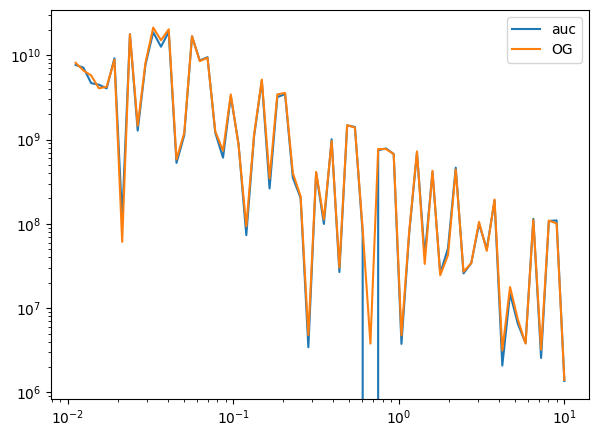

In [16]:
y = np.dot(shots[0], R)
for i in range(n):
  y += np.dot(shots[i], R)

qr_guess = recover_energy_dist(R, y)
#plt.plot(gamma_bins[1:]/GeV, qr_guess[0]/dE/(1/GeV), label="QR")
plt.plot(gamma_bins[1:]/GeV, auc/dE/(1/GeV), label="auc")
plt.plot(gamma_bins[1:]/GeV, arb_gamma_distribution[0]/dE/(1/GeV), label="OG")
plt.legend()
plt.yscale("log")
plt.xscale("log")

In [17]:
avg_error = 0
x = np.zeros(shape=(1, 64))
num_of_runs = 20
for counter in range(num_of_runs):
  arb_gamma_distribution = np.zeros(shape=(1,64))
  n = 111 #number of energy subdistributions
  max_loc_value = n//2
  max_offset_length = 10 # mm
  max_skew = 8
  shots = np.zeros(shape=(n, 64))
  for k in range(0, 64):
    interval_index = np.random.randint(5,6)
    arb_gamma_distribution[0][k] = np.random.randint(10**(interval_index-1), 10**(interval_index+1))
    for photon in range(int(arb_gamma_distribution[0][k]/1e04)):
      offset = (max_offset_length-2)*k/64
      skew = max_skew*k/64

      alpha = 1
      if np.random.choice([0,1]) == 0:
        alpha = -1

      random_location = skewnorm.rvs(alpha, size=1)[0] + alpha*offset

      if random_location > 11:
        random_location = 11
      elif random_location < -11:
        random_location = -11

      random_location = int(np.round(random_location*max_loc_value/10))

      shots[random_location][k] += 1e04

  test = [ [] for _ in range(64) ]
  step_size = 7
  for j in range(64):
    for i in range(0, 110, step_size):
      test[j].append(shots[i][j])

  auc = []
  for j in range(64):
    area_to_append = 0
    for i in range(len(test[j])-1):
      area_to_append += step_size*(test[j][i]+test[j][i+1])/2
    auc.append(area_to_append)

  avg_error += np.mean(np.abs(arb_gamma_distribution[0] - auc)/arb_gamma_distribution[0])
  temp = arb_gamma_distribution[0]/auc
  temp[temp == np.inf] = 0
  x += temp


<ipython-input-17-b1e0e9d4a280>:47: RuntimeWarning: divide by zero encountered in true_divide
  temp = arb_gamma_distribution[0]/auc


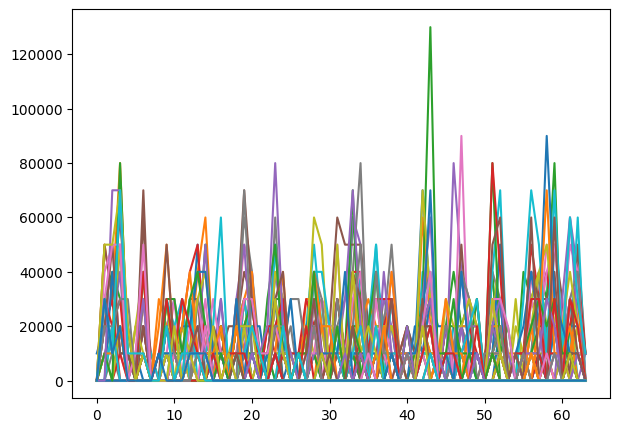

In [18]:
for i in range(n):
  plt.plot(shots[i], label = i)

<ipython-input-5-1248c4deab17>:192: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  guess = np.linalg.lstsq(S,b[0],) # || S*guess - b ||_2 = 0


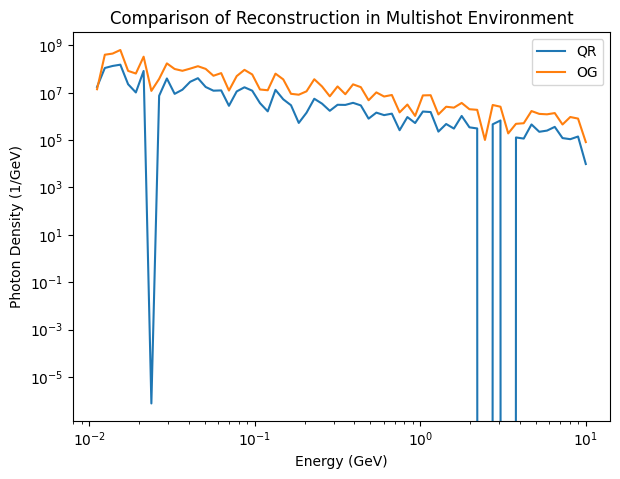

In [19]:
y = np.dot(shots[0], R)
for i in range(23):
  y += np.dot(shots[i*5], R)


qr_guess = recover_energy_dist(R, y)
hybrid_guess = iterate_shepp_vardi(qr_guess[0], R, y)
for i in range(50):
  hybrid_guess = iterate_shepp_vardi(hybrid_guess, R, y)

plt.plot(gamma_bins[1:]/GeV, hybrid_guess/dE/(1/GeV), label="QR")
plt.plot(gamma_bins[1:]/GeV, arb_gamma_distribution[0]/dE/(1/GeV), label="OG")
plt.xlabel("Energy (GeV)")
plt.ylabel("Photon Density (1/GeV)")
plt.yscale("log")
plt.xscale("log")
plt.title("Comparison of Reconstruction in Multishot Environment")
plt.legend()

# Graveyard

In [ ]:
def plot_spectral_photon_density(
        ax, fin, group_name, E_lim, num_photons_simulated, gamma_bins):
    mrad = 0.001
    joule = 1.0
    g = fin[group_name]
    photon_energy = g['energy'][:]*MeV
    thetax = g['thetax'][:]*mrad
    thetay = g['thetay'][:]*mrad
    d2W = g['d2W'][:]*joule/(mrad**2*MeV)
    dthetax = thetax[1]-thetax[0]
    dthetay = thetay[1]-thetay[0]

    spectral_energy_density = d2W.sum(axis=(1,2))*dthetax*dthetay
    spectral_photon_density = spectral_energy_density/photon_energy

    mask = spectral_energy_density>0

    idx = range(*photon_energy.searchsorted(E_lim))
    num_photons_lim = simps(spectral_photon_density[idx], photon_energy[idx])
    alpha = num_photons_simulated/num_photons_lim

    ax.loglog(
        np.concatenate(((0.0,), photon_energy[mask]/GeV)),
        alpha*np.concatenate(((0.0,), spectral_photon_density[mask]/(1/GeV))),
        linewidth=0.6, label='Incident gamma spectrum')
    return generate_short_true_spectrum(np.concatenate(((0.0,), photon_energy[mask]/GeV)),
        alpha*np.concatenate(((0.0,), spectral_photon_density[mask]/(1/GeV))))
    #photon_energy[mask]/GeV * (alpha * spectral_photon_density[mask]/(1/GeV))


In [ ]:
#Junkyard
#Plotting the different reconstructions and the original gamma distribution for comparison
def temp_plot(guess, true_dist, title):
  plot.plot(np.abs(guess), label = title)
  plot.plot(true_dist*dE/GeV, label = "Gamma distribution")
  plot.xlabel("Energy Bin")
  plot.ylabel("Number of Photons")
  plot.yscale("log")
  #plot.ylim([1e04, 2e08])
  plot.legend()

In [ ]:
plot.plot(np.abs(qr_guess[0]), label = "QR based prediction")
plot.plot(np.abs(mle_guess), label = "MLE based prediction")
plot.plot(np.abs(model_guess), label = "Model based prediction")
plot.plot(gamma_dist*dE/GeV, label = "Gamma distribution")
plot.xlabel("Energy Bin")
plot.ylabel("Number of Photons")
plot.yscale("log")
plot.ylim([1e05, 2e08])
plot.legend()

In [ ]:
#Plotting the different reconstructions and the original gamma distribution for comparison
temp_plot(mle_guess, gamma_dist, "MLE based prediction")

In [ ]:
temp_plot(model_guess, gamma_dist, "Model based prediction")

In [ ]:
gamma_bins[0:29]/GeV